# GAN's: Changing Styles of Photos to Monet Paintings
#### Kate Pendavinji


**Brief description of the problem and data:** The challenge problem here is to change a real photo into the style of monet using GAN's. In our data we have 5 monet TFRecord files and 20 photo TFRecord files. We have 7038 photos that we need to convert into monet paintings.

A generative adversarial network will train two neural networks against each other in order to emulate a monet painting. We have four folders two of which have photo and monet images and the other two have aforementioned TFRecord files which we will parse through. We will conduct this below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import string
from collections import Counter
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

AUTOTUNE = tf.data.experimental.AUTOTUNE


#Exploratory Data Analysis

Below you will see my exploratory data analysis. I followed the instructions of the kaggle project and located Amy Jang's tutorial for uploading and parsing through TFRecord Files. I initialized our data framses and outputted the first 3 photos of the datasets.

In [94]:
monet_filenames = tf.io.gfile.glob('/content/drive/My Drive/GAN/monet_tfrec/*.tfrec')
photo_filenames = tf.io.gfile.glob('/content/drive/My Drive/GAN/photo_tfrec/*.tfrec')

print("Monet TFRecord Files:", len(monet_filenames))
print("Photo TFRecord Files:", len(photo_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


# **LOADING TFRECORDS FROM AMY JANG'S NOTEBOOK AS INSTRUCTED BY KAGGLE**
# **"We highly recommend Amy Jang's notebook that goes over the basics of loading data from TFRecords":**
# [**AMY JANG'S NOTEBOOK**](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial)

In [130]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(32)

monet_images = next(iter(monet_ds))
photo_images = next(iter(photo_ds))

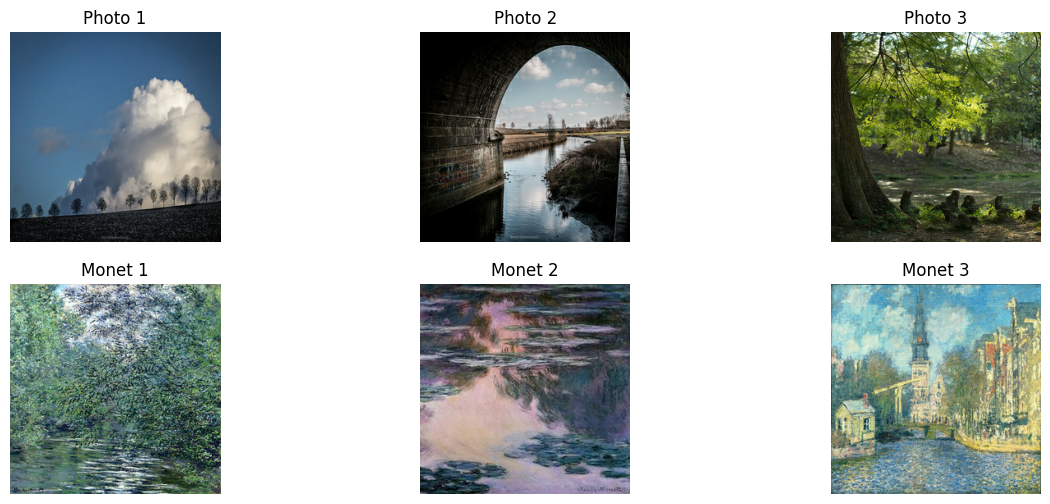

In [117]:
photo_images = list(photo_ds.take(3))
monet_images = list(monet_ds.take(3))

plt.figure(figsize=(15, 6))


plt.subplot(2, 3, 1)
plt.title('Photo 1')
plt.imshow((photo_images[0][0] * 0.5 + 0.5).numpy())
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Photo 2')
plt.imshow((photo_images[1][0] * 0.5 + 0.5).numpy())
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Photo 3')
plt.imshow((photo_images[2][0] * 0.5 + 0.5).numpy())
plt.axis('off')


plt.subplot(2, 3, 4)
plt.title('Monet 1')
plt.imshow((monet_images[0][0] * 0.5 + 0.5).numpy())
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Monet 2')
plt.imshow((monet_images[1][0] * 0.5 + 0.5).numpy())
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Monet 3')
plt.imshow((monet_images[2][0]  * 0.5 + 0.5).numpy())
plt.axis('off')

plt.show()

# Model Architecture

The model architecture will be utilizing DCGANS as it is what I am the most familiar from from lecture. I will be strongly using the [keras guide](https://keras.io/examples/generative/dcgan_overriding_train_step/) sourced from our class material to be executing this. I chose DCGANS because they are great at generating images, especially those that share a fuzzy resemblence. I feel this would match Monet's art style the most. Based on the looks of the exploratory data analysis that is what I concluded.

We will start with the following architecture:

* generator model
  - this will generate the lookalike Monet photos based on waht we feed it.
* discriminator model
  - this will distinguish the difference between our made up Monet photos and the real ones.
* compile
  - this sets up our models to be compiles.
* generator training
  - this updates our data weights to really imporve on making our photos look like monet paintings.
* discriminator training
  - this works on solidifying telling the difference between Monet paintings and photos turned into Monet paintings.  

In [135]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback


def preprocess_images(images):
    return tf.image.resize(images, [64, 64])

photo_ds = load_dataset(photo_filenames).map(preprocess_images).batch(32).prefetch(tf.data.AUTOTUNE)


def generator_model():
    model = tf.keras.Sequential([
        # layer wit 8*8*256 unit because our photos are 256 as stated in kaggle
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        # activate gradient (like guide)
        layers.LeakyReLU(),
        # dims we want-- struggled a lot with getting my dimensions right
        layers.Reshape((8, 8, 256)),
        # conv layer
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        #activate
        layers.LeakyReLU(),
        # conv layer model
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.LeakyReLU(),
        # conv layer model
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


def discriminator_model():
    model = tf.keras.Sequential([
        # shapey conv
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]),
        layers.LeakyReLU(),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        # regularization
        layers.Dropout(0.3),
        layers.Flatten(),
        # prob (lecture)
        layers.Dense(1)
    ])
    return model


generator = generator_model()
discriminator = discriminator_model()


class GAN(Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")

    def compile(self, gen_optimizer, disc_optimizer, loss_fn):
        super(GAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # fake images
        generated_images = self.generator(random_latent_vectors, training=True)

        # combine the two
        real_images_resized = tf.image.resize(real_images, [64, 64])
        combined_images = tf.concat([real_images_resized, generated_images], axis=0)

        # assemble labels and noise
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # discwiminatow twaining
        with tf.GradientTape() as disc_tape:
            predictions = self.discriminator(combined_images, training=True)
            disc_loss = self.loss_fn(labels, predictions)
        grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # noisey i like it monet
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        #genewatow twaining
        with tf.GradientTape() as gen_tape:
            predictions = self.discriminator(self.generator(random_latent_vectors, training=True), training=True)
            gen_loss = self.loss_fn(misleading_labels, predictions)
        grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))


        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        return {"gen_loss": self.gen_loss_tracker.result(), "disc_loss": self.disc_loss_tracker.result()}


latent_dim = 100
gan = GAN(generator=generator, discriminator=discriminator, latent_dim=latent_dim)

#twaininggggggg
gan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(1e-4),
    disc_optimizer=tf.keras.optimizers.Adam(1e-4),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

gan.fit(photo_ds, epochs=10, steps_per_epoch=10)


Epoch 1/10
10/10 [==============================] - 16s 1s/step - gen_loss: 0.6700 - disc_loss: 0.5400
Epoch 2/10
10/10 [==============================] - 15s 2s/step - gen_loss: 0.5437 - disc_loss: 0.4343
Epoch 3/10
10/10 [==============================] - 17s 2s/step - gen_loss: 0.8099 - disc_loss: 0.3106
Epoch 4/10
10/10 [==============================] - 18s 2s/step - gen_loss: 1.5586 - disc_loss: 0.1163
Epoch 5/10
10/10 [==============================] - 15s 1s/step - gen_loss: 0.8053 - disc_loss: 0.2948
Epoch 6/10
10/10 [==============================] - 14s 1s/step - gen_loss: 0.3645 - disc_loss: 0.6225
Epoch 7/10
10/10 [==============================] - 17s 2s/step - gen_loss: 0.6955 - disc_loss: 0.4383
Epoch 8/10
10/10 [==============================] - 15s 2s/step - gen_loss: 0.6792 - disc_loss: 0.4792
Epoch 9/10
10/10 [==============================] - 13s 1s/step - gen_loss: 2.8983 - disc_loss: 0.0832
Epoch 10/10
10/10 [==============================] - 14s 1s/step - gen_lo

In [136]:
generator.summary()
discriminator.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 16384)             1638400   
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_13 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_39 (Conv2  (None, 16, 16, 128)       819200    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_40 (Conv2  (None, 32, 32, 64)        204800    
 DTranspose)                                         

# Results and Analysis

After running our generator and discriminator training, our generator and discriminators produce photos that look like our Monet paintings much better than they would have before.

Things I would have done better would be making my DCGAN faster. I was only able to upload 1 epoch per 10+ m inutes due to how horribly it long it took to run my DCGAN. I should have increased batch size even more, but I just ran out of time to modify the huge thing I already have . I would have maybe normalized my data a little better and also vizualized it more.

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense_26 (Dense)            (None, 16384)             1638400   
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_13 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_39 (Conv2  (None, 16, 16, 128)       819200    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_40 (Conv2  (None, 32, 32, 64)        204800    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_41 (Conv2  (None, 64, 64, 3)         4800      
 DTranspose)                                                     
                                                                 
=================================================================
Total params: 2667200 (10.17 MB)
Trainable params: 2667200 (10.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_26 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 flatten_13 (Flatten)        (None, 32768)             0         
                                                                 
 dense_27 (Dense)            (None, 1)                 32769     
                                                                 
=================================================================
Total params: 242561 (947.50 KB)
Trainable params: 242561 (947.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/10
10/10 [==============================] - 16s 1s/step - gen_loss: 0.6700 - disc_loss: 0.5400
Epoch 2/10
10/10 [==============================] - 15s 2s/step - gen_loss: 0.5437 - disc_loss: 0.4343
Epoch 3/10
10/10 [==============================] - 17s 2s/step - gen_loss: 0.8099 - disc_loss: 0.3106
Epoch 4/10
10/10 [==============================] - 18s 2s/step - gen_loss: 1.5586 - disc_loss: 0.1163
Epoch 5/10
10/10 [==============================] - 15s 1s/step - gen_loss: 0.8053 - disc_loss: 0.2948
Epoch 6/10
10/10 [==============================] - 14s 1s/step - gen_loss: 0.3645 - disc_loss: 0.6225
Epoch 7/10
10/10 [==============================] - 17s 2s/step - gen_loss: 0.6955 - disc_loss: 0.4383
Epoch 8/10
10/10 [==============================] - 15s 2s/step - gen_loss: 0.6792 - disc_loss: 0.4792
Epoch 9/10
10/10 [==============================] - 13s 1s/step - gen_loss: 2.8983 - disc_loss: 0.0832
Epoch 10/10
10/10 [==============================] - 14s 1s/step - gen_loss: 1.8925 - disc_loss: 0.3155





# Conclusion

Overall DCGan did a great job at changing a real photo into the style of monet using GAN's. We were able to train two neural networks against each other in order to emulate a monet painting and parse through our TFREcords.